The goal of this milestone is for you to scrape data from an actual website and start to analyze the results. The project should be completed in individually in python without the assistance of any artificial intelligences.

Web Scraper - Take all of the text from the top 20 articles coming from one of the following web news sources:

espn.com
cnn.com
goodblacknews.org
huffingtonpost.com
ign.com
theonion.com

Statistics - Print a list of the titles of the web pages you are pulling text from and then print the mean and median number of words for all 20 articles.

Visualize - Create a Word Cloud using your list of most common words that shows the top 50 (or up to 200) words and a bar chart to show the relative frequencies of the top 15 most frequent words. (Note: these should be words that the average viewer of the website would see, not code from the html)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liamz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liamz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#
12 year-round lawn care tips | CNN - Good Sentiment at compound score = 0.9989
Sophia Loren has surgery after fall | CNN - Good Sentiment at compound score = 0.296
Benjamin Netanyahu asks Elon Musk to 'roll back' antisemitism on X | CNN Business - Good Sentiment at compound score = 0.9866
OSIRIS-APEX mission sets off for new asteroid target | CNN - Good Sentiment at compound score = 0.8316
Why you should be traveling to Europe in fall, not summer | CNN - Good Sentiment at compound score = 0.9998
Free Covid-19 tests are now available for order from the US government | CNN - Good Sentiment at compound score = 0.8674
Why you should be traveling to Europe in fall, not summer | CNN - Good Sentiment at compound score = 0.9998
California seals its reputation as a climate juggernaut with a wave of legislation and head-turning lawsuit | CNN - Good Sentiment at compound score = 0.924
David McCallum: 'NCIS' star dead at 90 | CNN - Good Sentiment at compound score = 0.7465
Travel news: This airp

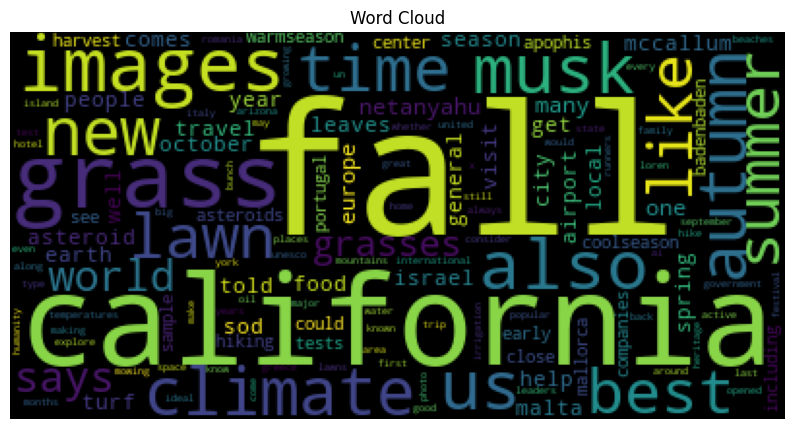

('fall', 37)
('california', 37)
('grass', 32)
('images', 32)
('also', 27)
('us', 25)
('musk', 25)
('new', 24)
('autumn', 24)
('climate', 24)
('time', 23)
('lawn', 21)
('best', 21)
('like', 21)
('summer', 21)


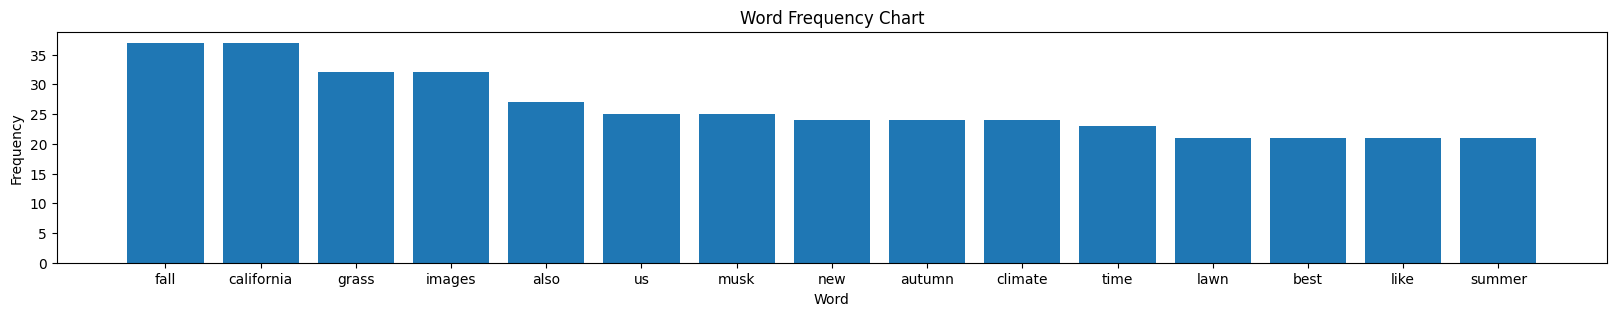

In [18]:
# IDS Project 1 Milestone 3
# Liam Zalubas
# help coming from https://lxml.de/parsing.html#parsers for lxml documentation
from bs4 import BeautifulSoup as bs
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import requests
import string
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
nltk.download("punkt")
nltk.download('stopwords')

# change this to check more articles
articlesToUse:int = 0
wordsForCloud:int = 50
wordsForGraph:int = 15
base_url = "https://www.cnn.com"

# some resources to use for string filtering/cleaning
punc = str.maketrans('', '', string.punctuation)
stop_words = stopwords.words("english")
# beautiful soup symbols to remove
unwantedThings = {'“', '”', '–', '’s', '—', '’','•'}
# list of words to add to stoplist, including CNN-specific page elements
unwantedWords = {"said", "feedback", "cnn", "source", "ad", "image", "video"}
# specific words to add to stopwords filter
for word in unwantedWords:
    stop_words.append(word)
    
# addition of sentiment analysis tool
sentiment_tool = sia()

# start program here: get the main page from #! base_url
response = requests.get(base_url)
# response encoding is utf-8

with open("main_page.html", "wb") as htmlFile:
    htmlFile.write(response.content)

# now we have main page downloaded, and we can parse it for article links
# THE ENCODING PART HERE IS REALLY IMPORTANT OR ELSE NOTHING WORKS
fileWrap = open("main_page.html", "r", encoding="utf-8")

# this converts the open file into a single string variable
fileText: str = fileWrap.read()

# turning the downloaded file into a BS4 object
bsText = bs(fileText, "html.parser")

# list to store all valid article links
articles = []

# get all the potential links that match patterns of articles
for link in bsText.find_all('a'):
    currentLink: str = link.get('href')
    try:
        # pattern to save: all articles start with "/" and end with ".html"
        if (currentLink.startswith('/') and currentLink.endswith('.html')):
            articles.append(base_url+currentLink)
    except:
        print("#")

while (articlesToUse < 1 or articlesToUse > len(articles)):
    articlesToUse = int(input("How many articles do you want to process?\n")) 

# now that we have all the articles, we pick {randomArticleCount:int} at random and analyze the results
# start with a list to put our words and their frequencies in
wordsList = {}

# and one for the titles to use later
titleArray = []

#article word counts to use as data for statistics
articleWordCounts = [0 for i in range(articlesToUse)]
articleSentiment = []


# method to scrub words and pass them to the adder method
def cleanWord(thisWord:str, articleNum:int):
    cleanedWord = thisWord
    
    # remove all numbers: if a number is found, return without adding word
    for num in range(0,9):
        if (cleanedWord.find(str(num)) != -1):
            return

    # make it all lowercase and remove most punctuation
    cleanedWord = cleanedWord.casefold().translate(punc)
    # temporary fix for manually-identified punctuation outliers 
    for symbol in unwantedThings:
        cleanedWord = cleanedWord.replace(symbol, ' ').strip()
    # completely ditch the word if it's just an empty string
    if (cleanedWord != ''):
        # if the above operations turned the word into multiple words, recurse this method for each new word
        if (cleanedWord.find(' ') != -1):
            cleanedWord.split()
            for i in range(len(cleanedWord)):
                cleanWord(cleanedWord[i], articleNum)
                
        # make sure the word is not a stopword before taking it into account
        if cleanedWord not in stop_words:
            incrementWord(cleanedWord, articleNum)
    else:
        return

# this is a method to send valid words into wordsList or increment their count
def incrementWord(thisWord: str, articleNum:int):
    # add 1 to the article's word count
    articleWordCounts[articleNum] += 1
    # for each word key in the dictionary:
    # if already exists, add one to the frequency counter
    # else, add it to the words list and start at frequency=1
    if thisWord in wordsList:
        wordsList[thisWord] += 1
    else:
        wordsList[thisWord] = 1

#randomize the links within the list, then use the first {articlesToUse:int} articles.
np.random.shuffle(articles)

for i in range(articlesToUse):
    # turns the entire request page into a BS4 object
    thisArticle = bs(requests.get(articles[i]).text, "html.parser")
    
    # print the name of the article we're about to check
    print(thisArticle.title.text, end=" ")# type:ignore
    
    titleArray.append((thisArticle.title.text).replace(" | CNN",""))# type:ignore
    
    # now narrow down the text we're interested in to just the article itself
    # for each piece of text in a new tag from the last, insert a space between them
    textBlocks = thisArticle.article.get_text(strip=True, separator='\n').splitlines() # type:ignore
    
    # make it all a single string (separated with spaces)
    bigString:str = ''
    for block in textBlocks:
        bigString += ' ' + block
    
    # here is where we run sentiment analysis, since we have proper sentence structure to pass to VADER
    score = sentiment_tool.polarity_scores(bigString)
    articleSentiment.append(score.get('compound'))
    """
    From VADER site:
    positive sentiment: compound score >= 0.05
    neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    negative sentiment: compound score <= -0.05
    """
    if(articleSentiment[i] >= 0.05):
        print("- Good Sentiment at compound score =",articleSentiment[i])
    elif(articleSentiment[i] <= -0.05):
        print("- Bad Sentiment at compound score =",articleSentiment[i])
    else:
        print("- Neutral Sentiment at compound score =",articleSentiment[i])
    # now we tokenize based on single words instead of blocks
    bigTokens = nltk.word_tokenize(bigString)
    
    # then iterate through all tokens we have
    for word in bigTokens:
        cleanWord(word, i)


# Sort the word counts in descending order.
sortedWordsList = sorted(wordsList.items(), key=lambda item: item[1], reverse=True)

#print the mean and median values for word count
print("\nMean word count:",np.average(articleWordCounts))
for i in range(len(articleWordCounts)):
    print(articleWordCounts[i],"words in article:",titleArray[i])
print("Median word count:",articleWordCounts[int(len(articleWordCounts)/2)])

avg_sentiment = 0
for sentiment in articleSentiment:
    avg_sentiment += sentiment
avg_sentiment /= articlesToUse

print("Average sentiment:",avg_sentiment)

if avg_sentiment > 0:
    print("Overall good sentiment!")
else:
    print("Overall bad sentiment!")

# too many words to fit on the word cloud, here we cut the end of the list
while (len(sortedWordsList) > wordsForCloud):
    sortedWordsList.pop()

# now we make the word cloud with 50 words
# Create a WordCloud object.
wordcloud = WordCloud()

# Generate the word cloud.
wordcloud.generate_from_frequencies(wordsList)

# Display the word cloud.
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud")
plt.show()

# now we drop more words to fit the bar chart
while (len(sortedWordsList) > wordsForGraph):
    sortedWordsList.pop()

for word in sortedWordsList:
    print(word)
    
# Create a bar chart.
plt.figure(figsize=(20, 3))
plt.bar([word for word, count in sortedWordsList],
        [count for word, count in sortedWordsList])
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Word Frequency Chart")
plt.show()


# Written Analysis

## Scenario 1: Imagine that you work for a company that sells a variety of tennis equipment and you could analyze the user reviews for each product in the same way you analyzed the articles from the above news sources. What could be the benefit of your analysis to your company? Is there a benefit your customers? If another site collected similar data, ratings of your products, who owns that data and what parties are involved?

User reviews can be a valuable source of information for both companies and customers. For companies, user reviews can help identify product strengths and weaknesses (mainly through the extremes seen in sentiment analysis), track customer satisfaction over time (trends of sentiment for a product or series of products), identify common customer problems (common words paired with strong, negative sentiment), and benchmark products against competitors (do the same analysis for similar products). For customers, it depends on if they get to access the review analysis findings theirselves, or only get to benefit from what the company finds from this analysis. User reviews generally help customers make informed purchase decisions, identify products that are a good fit for their needs, and also get help with product troubleshooting if others have had similar issues. The data ownership and parties involved section concerns who owns the user reviews that are collected on websites and how that data is used. Primarily, the website where the reviews are collected owns the data, but the company that owns the products being reviewed may also use the data to improve its products and customer service. Additionally, third-party data analytics companies may analyze the reviews to provide insights to the website and the company that owns the products being reviewed. Customers who write reviews own their own reviews, but they may grant the website and the company that owns the products being reviewed a license to use the reviews depending on the terms of use for that specific site.

## Scenario 2: Suppose you had access to the social media accounts of the people in your social circle and could analyze their posts in the same way you analyzed the articles from the above news sources. What do you think you could learn about each individual after doing this? How do you think they would feel about you doing that? and would it matter if you told them what you were doing or if they found out some other way? Would it make a difference if you could also analyze all of their private messages as well?

While there's a lot of analysis that you can perform on public social media posts, I would find a few things to be most interesting: timing, location, and common word use data. Timing would involve the specific times people choose to post and/or comment using their account, letting you know when they most frequently use said social media account. Location data, assuming the media site contains it (such as snapchat or other services which tag your location at the time of a post) would narrow down exactly where someone is at a given time they use their account. Common word use could provide some unique insights into what a person is interested in, and would be very tempting to have if you were a company trying to sell a particular product to people. On one hand, I can understand people feeling exposed or uncomfortable with these kinds of data analysis, as it may feel like i'd be going too far into personal information. On the other hand, if this information was publicly available (as opposed to being from accounts which are invite-only/friends-only limited), I would be surprised if people called it an invasion of privacy. Telling someone about analyzing their data upfront would definitely feel less shady as opposed to having them find out some other way. This moderately ties into the idea of asking for forgiveness instead of permission: you wouldn't want to ruin your reputation with friends just because of a data analysis project in which you use their information without their knowledge rather than being upfront and honest. It would absolutely make a difference having private messages, and the amount of extra information that would bring in would be a whole new project in itself. 